In [1]:
import sys
sys.path.append("/home/isabrah/sustainable_high_quality_wikis")
import numpy as np
import pandas as pd
from promotion_demotion_dates_utils import determine_promotion_demotion_dates, load_and_decompress
from os.path import join as opj
from tqdm import tqdm
import glob
import os
from datetime import datetime
from collections import defaultdict, Counter
from modeling.modeling_utils import gini_coefficient
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import pickle
import multiprocess as mp
import re
from tqdm import tqdm
import bz2
import jsonlines


### Configurations

In [2]:
def extract_talkpage_meta_data(page_id, talkpage_file_path, article_obj_file_path, usecase):
    article_assessment_obj = pickle.load(open(article_obj_file_path, "rb"))
    talkpage_data = load_and_decompress(filename=talkpage_file_path)
    is_valid = article_assessment_obj.is_obj_valid(usecase)
    if not is_valid:
        return {-1: -1}
    is_high_quality = article_assessment_obj.is_sustainable
    promotion_date = article_assessment_obj.fa_promotion_date if usecase == 'fa' else article_assessment_obj.ga_promotion_date
    if type(promotion_date) is not datetime:
        return IOError(f"Invalid promotion date for article {article_assessment_obj.article_id}")
    try:
        discussion_features_dict = extract_discussion_features(data=talkpage_data, promotion_time=promotion_date)
        discussion_features_dict['sustainable'] = is_high_quality
        return {page_id: discussion_features_dict}
    except ValueError as e:
        return {-2: -2}

In [3]:
def is_discussion_relevant(discussion_info, promotion_time):
    cur_time = discussion_info['time'].replace(",", "")
    time_formats = ['%H:%M %d %b %Y (%Z)', '%H:%M %b %d %Y (%Z)', '%H:%M %d %B %Y (%Z)', '%H:%M:%S %Y-%m-%d (%Z)', '%H:%M %B %d %Y (%Z)']
    time_format_testing_idx = 0
    while True:
        try:
            discussion_datetime = datetime.strptime(cur_time, time_formats[time_format_testing_idx])
            break
        except ValueError as e:
            time_format_testing_idx += 1
            if time_format_testing_idx == len(time_formats):
                raise e
    if discussion_datetime < promotion_time:
        return True
    # if we did not return True by now, we return False by default
    return False

In [4]:
def extract_discussion_features(data, promotion_time):
    num_discussions = 0
    mixed_authors_comments = 0 # these are wired cases, where two authors are sharing a comment (unreliable ones)
    authors_dict = defaultdict(int)
    sentiment = list()
    formality = list()
    politeness = list()
    toxicity = list()
    certainty = list()
    # looping over each item in the list and extracting information about the discussion
    for cd in data:
        is_relevant = is_discussion_relevant(discussion_info=cd, promotion_time=promotion_time)
        if not is_relevant:
            continue
        if 'comments' not in cd:
            continue
        # if we got up to here, it means that the comment is relevant and we can loop over all comments in the section (in case there are, there should be...)
        num_discussions += 1
        for comment in cd['comments']:
            cur_author = comment['author']
            authors_dict[cur_author] += 1
            num_talk_regex = re.findall("(talk)", comment['text'])
            mixed_authors_comments += 1 if len(num_talk_regex) > 1 else 0
            if 'dl_preds' in comment:
                sentiment.append(comment['dl_preds']['sentiment'])
                formality.append(comment['dl_preds']['formality'])
                politeness.append(comment['dl_preds']['politeness'])
                toxicity.append(comment['dl_preds']['toxicity'])
                certainty.append(comment['dl_preds']['certainty'])
    gini_measure = gini_coefficient(authors_dict) if authors_dict else None
    num_authors = len(authors_dict)
    num_comments = sum(authors_dict.values())
    return {'num_discussions': num_discussions, 'num_comments': num_comments, 'num_authors': num_authors, 
            'gini_measure': gini_measure, 'mixed_authors_comments': mixed_authors_comments,
            'sentiment_mean': np.nanmean(sentiment), 'formality_mean': np.nanmean(formality),
            'politeness_mean': np.nanmean(politeness), 'toxicity_mean': np.nanmean(toxicity), 'certainty_mean': np.nanmean(certainty)}

In [8]:
# an example of how the talk pages structure looks like
sample_data = load_and_decompress(filename='/shared/3/projects/relationship-aware-networks-wikipedia/wiki_generated_data/talkpage_discussions_with_dl_preds/896.jsonl.bz2')

In [9]:
len(sample_data)

31

In [14]:
sample_data[4]#['comments'][0]['dl_preds']

{'talk_page_id': 62011607,
 'rev_id': 1136529218,
 'title': ' Dangers of argon should be mentioned ',
 'section_id': 5,
 'time': '15:09, 25 July 2007 (UTC)',
 'comments': [{'comment_id': 7,
   'time': '15:09, 25 July 2007 (UTC)',
   'author': 'Slowmover',
   'author_id': 777454,
   'refers_to_comment_id': None,
   'root_comment_id': 7,
   'refers_to': None,
   'refers_to_author_id': None,
   'root_author': 'Slowmover',
   'root_author_id': 777454,
   'depth': 0,
   'text': "Dangers of argon should be mentioned \n\nArgon has been cited in several cases of accidental suffocation. Here's one example. Argon is denser than N2 or O2 and will sink to the bottom of an enclosed space.  Since it is odorless and colorless, it is undetectible by ordinary means.  Argon only needs to displace a small portion of the oxygen in the air before dizziness and unconsciousness result.  See here and here. Slowmover 15:09, 25 July 2007 (UTC)",
   'dl_preds': {'sentiment': 0.0083300014957785,
    'formality': 

### Data Loading

In [8]:
data_folder = '/shared/3/projects/relationship-aware-networks-wikipedia/wiki_generated_data/'
metadata_files_folder = opj(data_folder, 'meta_data')
meta_data_file_full_path = opj(metadata_files_folder, 'sustainability_research_meta_info_per_article.csv')
meta_data_df = pd.read_csv(meta_data_file_full_path)
# removing the single page that the title was not found (probably deleted)
meta_data_df = meta_data_df[~meta_data_df['page_title'].isna()]
print(f"Overall we have {meta_data_df.shape[0]} instances")

Overall we have 46303 instances


### Analysis of FA/GA cases

In [9]:
usecase = 'ga'
pickle_files_folder = opj(data_folder, 'article_assessment_objs', 'good_articles') \
    if usecase == 'ga' else opj(data_folder, 'article_assessment_objs', 'featured_articles')
# in both cases of good/featured, we have to add the 'both' folder
pickle_files_folder = [pickle_files_folder, opj(data_folder, 'article_assessment_objs', 'both')]
pickle_files_path = sorted(list(itertools.chain(*[glob.glob(opj(pff, '*.p')) for pff in pickle_files_folder])))
page_id_to_pickle_file_mapping = {int(pfp.split('/')[-1].split('.p')[0]): pfp for pfp in pickle_files_path}
print(f"There are {len(page_id_to_pickle_file_mapping)} pages for this usecase to analyze")

There are 42536 pages for this usecase to analyze


In [10]:
talkpages_data_path = opj(data_folder, 'talkpage_discussions_with_dl_preds')
talkpages_existing_files = os.listdir(talkpages_data_path)
required_page_ids = set(page_id_to_pickle_file_mapping.keys())
page_id_to_talkpage_file_mapping = {int(ef.split('.jsonl.bz2')[0]): opj(data_folder, 'talkpage_discussions_with_dl_preds', ef) for ef in talkpages_existing_files if int(ef.split('.jsonl.bz2')[0]) in required_page_ids}
print(f"We have found {len(page_id_to_talkpage_file_mapping)} files from the {usecase} usecase that we can analyze")

We have found 41963 files from the ga usecase that we can analyze


In [11]:
# extracting meta info about each page. Doing it multiprocess, as we have to load 2 files per article
n_cpus = 100
# opening each file and extracting the relevant info. We will do it a multiprocess one since it takes a long time
input_for_pool = [(page_id, talkpage_file_path, page_id_to_pickle_file_mapping[page_id], usecase) for page_id, talkpage_file_path in page_id_to_talkpage_file_mapping.items()]
pool = mp.Pool(processes=n_cpus)
with pool as pool:
   results = pool.starmap(extract_talkpage_meta_data, input_for_pool)

/tmp/ipykernel_1759235/337925500.py:35: RuntimeWarning: Mean of empty slice
  'sentiment_mean': np.nanmean(sentiment), 'formality_mean': np.nanmean(formality),
/tmp/ipykernel_1759235/337925500.py:36: RuntimeWarning: Mean of empty slice
  'politeness_mean': np.nanmean(politeness), 'toxicity_mean': np.nanmean(toxicity), 'certainty_mean': np.nanmean(certainty)}
/tmp/ipykernel_1759235/337925500.py:35: RuntimeWarning: Mean of empty slice
  'sentiment_mean': np.nanmean(sentiment), 'formality_mean': np.nanmean(formality),
/tmp/ipykernel_1759235/337925500.py:36: RuntimeWarning: Mean of empty slice
  'politeness_mean': np.nanmean(politeness), 'toxicity_mean': np.nanmean(toxicity), 'certainty_mean': np.nanmean(certainty)}
/tmp/ipykernel_1759235/337925500.py:35: RuntimeWarning: Mean of empty slice
  'sentiment_mean': np.nanmean(sentiment), 'formality_mean': np.nanmean(formality),
/tmp/ipykernel_1759235/337925500.py:36: RuntimeWarning: Mean of empty slice
  'politeness_mean': np.nanmean(politeness

TypeError: 'NoneType' object is not subscriptable

In [12]:
errors_cnt = 0
features_dict = dict()
for r in tqdm(results):
    if list(r.keys())[0] > 0 :
        features_dict.update(r)
    else:
        errors_cnt += 1

100%|██████████| 41963/41963 [00:00<00:00, 146654.57it/s]


In [13]:
features_df = pd.DataFrame.from_dict(features_dict, orient='index')
Counter(features_df['sustainable'])

Counter({True: 38439, False: 3336})

In [14]:
features_df.head(10)

,num_discussions,num_comments,num_authors,gini_measure,mixed_authors_comments,sentiment_mean,formality_mean,politeness_mean,toxicity_mean,certainty_mean,sustainable
65288,1,3,2,0.166667,0,0.662718,0.496192,3.689153,0.000075,4.808135,True
31974,42,86,46,0.362993,4,0.339979,0.694598,3.497235,0.000172,4.582483,True
3402937,2,18,3,0.148148,0,0.886127,0.538983,3.769448,0.000040,4.591806,True
334265,5,16,11,0.238636,0,0.314229,0.824034,3.444195,0.000133,4.351336,True
195797,1,3,2,0.166667,0,0.662373,0.619287,3.712875,0.000039,4.746244,True
412996,12,16,13,0.173077,0,0.316127,0.718691,3.455011,0.000882,4.593449,True
3804026,1,1,1,0.000000,0,0.009958,0.657941,3.322525,0.000043,4.598668,True
2404959,3,9,6,0.240741,0,0.552674,0.529869,3.254662,0.000306,4.791136,False
30873388,8,40,8,0.618750,1,0.549503,0.584763,3.399456,0.000043,4.689741,True
191856,8,13,8,0.259615,0,0.537248,0.784415,3.489765,0.000041,4.633092,True


In [15]:
mixed_authors_comments_sum = sum(features_df['mixed_authors_comments'])
comments_sum = sum(features_df['num_comments'])
print(f"Overall there are {mixed_authors_comments_sum} cases if mixed authors comments, which is {round(100*mixed_authors_comments_sum/comments_sum, 2)}% of the data")

Overall there are 46619 cases if mixed authors comments, which is 3.36% of the data


The average :: median value of sentiment_mean for sustainable cases is 0.48635865026257247 :: 0.4991182437661337
The average :: median value of sentiment_mean for unsustainable cases is 0.4371454814294274 :: 0.41019140267532994


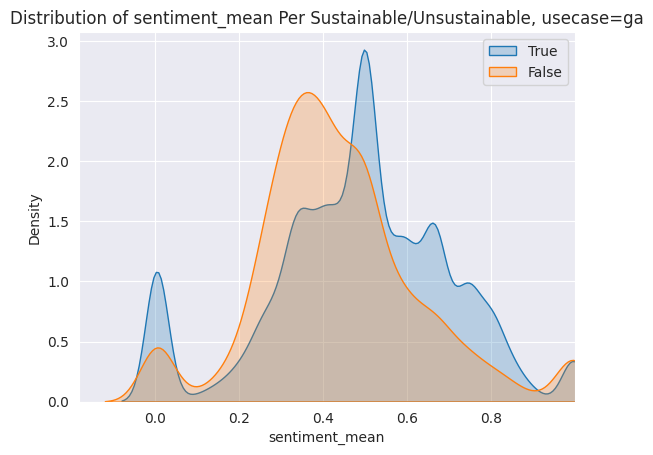

In [16]:
# plotting
feature_to_plot = 'sentiment_mean' #num_discussions' #gini_measure' #'num_authors' #'num_comments' #'mixed_authors_comments' #'politeness_mean' #'toxicity_mean' #'certainty_mean' #'sentiment_mean' # 'formality_mean'
feature_mean_sustainable = np.nanmean(features_df[features_df['sustainable'] == True][feature_to_plot])
feature_mean_unsustainable = np.nanmean(features_df[features_df['sustainable'] == False][feature_to_plot])
feature_median_sustainable = np.nanmedian(features_df[features_df['sustainable'] == True][feature_to_plot])
feature_median_unsustainable = np.nanmedian(features_df[features_df['sustainable'] == False][feature_to_plot])
print(f"The average :: median value of {feature_to_plot} for sustainable cases is {feature_mean_sustainable} :: {feature_median_sustainable}")
print(f"The average :: median value of {feature_to_plot} for unsustainable cases is {feature_mean_unsustainable} :: {feature_median_unsustainable}")
# Distribution for sustainable == True
sns.kdeplot(features_df[features_df['sustainable'] == True][feature_to_plot], label='True', fill=True)

# Distribution for sustainable == False
sns.kdeplot(features_df[features_df['sustainable'] == False][feature_to_plot], label='False', fill=True)

# heavy tali handling
quantile_true = features_df[features_df['sustainable'] == True][feature_to_plot].quantile(0.9999)
quantile_false = features_df[features_df['sustainable'] == False][feature_to_plot].quantile(0.9999)
# Determine the maximum x value based on the 0.99 quantile
max_x = max(quantile_true, quantile_false)


plt.title(f'Distribution of {feature_to_plot} Per Sustainable/Unsustainable, usecase={usecase}')
plt.xlabel(feature_to_plot)
plt.ylabel('Density')
plt.xlim(right=max_x)
plt.legend()
plt.show()